# PRÁCTICAS DE REDES NEURONALES ARTIFICIALES (TSCAO): Parte III


## 4. REDES NEURONALES DE FUNCIÓN BASE RADIAL

**Código para implementar una Red Neuronal RBF**

Vamos a implementar la función base radial:

In [8]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

Ahora necesitaremos usar el algoritmo de agrupación k-means para determinar los centros de los cluster. El siguiente código nos da los centros de clúster y las desviaciones estándar de los clústeres.

In [9]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
       Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
 
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

Este código implementa el algoritmo de clustering k-means y calcula las desviaciones estándar. Si hay un cluster con ninguno o uno de los puntos asignados, simplemente promediamos la desviación estándar de los otros grupos. (No podemos calcular la desviación estándar sin puntos de datos, y la desviación estándar de un solo punto de datos es 0).

Ahora implementaremos la clase RBF:

In [10]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True, verbose=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        self.verbose = verbose
 
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
                
    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
 
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
 
                loss = (y[i] - F).flatten() ** 2
                if self.verbose:
                    print('Loss: {0:.2f}'.format(loss[0]))
 
                # backward pass
                error = -(y[i] - F).flatten()
 
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
            
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

Tenemos varios parámetros que elegir para la RBF: el número de bases, la tasa de aprendizaje, la cantidad de épocas, y si queremos usar las desviaciones estándar de k-means. También inicializamos los pesos y el sesgo. Recordando que una red RBF es una red de 2 capas modificada, por lo que solo hay un vector de pesos y un solo sesgo en el nodo de salida, ya que estamos aproximando una función 1D (específicamente, una salida). Si tuviéramos una función con múltiples salidas (una función con una salida con valor vectorial), usaríamos múltiples neuronas
de salida y nuestros pesos serían una matriz y nuestro sesgo un vector.

Luego, tenemos que escribir nuestra función de ajuste para calcular nuestros pesos y sesgos. En las primeras líneas, usamos las desviaciones estándar del algoritmo k-medias modificado, o forzamos a todas las bases a usar la misma desviación estándar calculada a partir de la fórmula. El resto es similar a la propagación hacia atrás, donde propagamos nuestra entrada en el futuro y actualizamos nuestros pesos hacia atrás.

    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
 
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
 
                loss = (y[i] - F).flatten() ** 2
                print('Loss: {0:.2f}'.format(loss[0]))
 
                # backward pass
                error = -(y[i] - F).flatten()
 
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error

Se debe tener en cuenta que estamos imprimiendo el error en cada paso. También estamos realizando una actualización en línea, lo que significa que actualizamos nuestros pesos y sesgos para cada entrada.
Alternativamente, podríamos haber realizado una actualización por lotes, donde actualizamos nuestros parámetros después de ver todos los datos de entrenamiento, o una actualización de minibatch, donde actualizamos nuestros parámetros después de ver un subconjunto de los datos de entrenamiento.

Hacer una predicción será tan simple como propagar nuestra entrada hacia adelante:

    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

Hay que tener en cuenta que estamos permitiendo una matriz de entradas, donde cada fila es un ejemplo.

Ya podemos utilizar nuestro código para un ejemplo. Para nuestros datos de entrenamiento, generaremos 100 muestras de la función seno. Luego, agregaremos un poco de ruido uniforme a nuestros datos.

In [11]:
# CONFIGURACIÓN 1
import matplotlib.pyplot as plt
import numpy as np

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise
 
rbfnet = RBFNet(lr=1e-2, k=2)
rbfnet.fit(X, y)
 
y_pred = rbfnet.predict(X)

Loss: 1.32
Loss: 0.97
Loss: 0.95
Loss: 0.65
Loss: 0.79
Loss: 0.69
Loss: 0.56
Loss: 0.73
Loss: 0.77
Loss: 0.56
Loss: 0.50
Loss: 0.43
Loss: 0.40
Loss: 0.32
Loss: 0.38
Loss: 0.39
Loss: 0.23
Loss: 0.18
Loss: 0.18
Loss: 0.23
Loss: 0.25
Loss: 0.26
Loss: 0.13
Loss: 0.22
Loss: 0.18
Loss: 0.08
Loss: 0.07
Loss: 0.04
Loss: 0.08
Loss: 0.07
Loss: 0.10
Loss: 0.08
Loss: 0.05
Loss: 0.11
Loss: 0.14
Loss: 0.15
Loss: 0.24
Loss: 0.26
Loss: 0.25
Loss: 0.31
Loss: 0.29
Loss: 0.42
Loss: 0.37
Loss: 0.37
Loss: 0.51
Loss: 0.62
Loss: 0.64
Loss: 0.65
Loss: 0.99
Loss: 0.95
Loss: 0.80
Loss: 0.87
Loss: 0.88
Loss: 0.83
Loss: 1.01
Loss: 1.20
Loss: 1.07
Loss: 1.25
Loss: 1.01
Loss: 1.21
Loss: 1.62
Loss: 1.67
Loss: 1.59
Loss: 1.83
Loss: 2.07
Loss: 1.76
Loss: 1.64
Loss: 1.61
Loss: 2.06
Loss: 1.95
Loss: 2.03
Loss: 2.03
Loss: 1.97
Loss: 1.76
Loss: 2.01
Loss: 1.54
Loss: 1.83
Loss: 1.77
Loss: 1.57
Loss: 1.56
Loss: 1.22
Loss: 1.19
Loss: 1.43
Loss: 1.26
Loss: 1.03
Loss: 1.23
Loss: 0.89
Loss: 0.93
Loss: 0.86
Loss: 0.60
Loss: 0.64

Dibujamos nuestra función aproximada para compararla con la real:

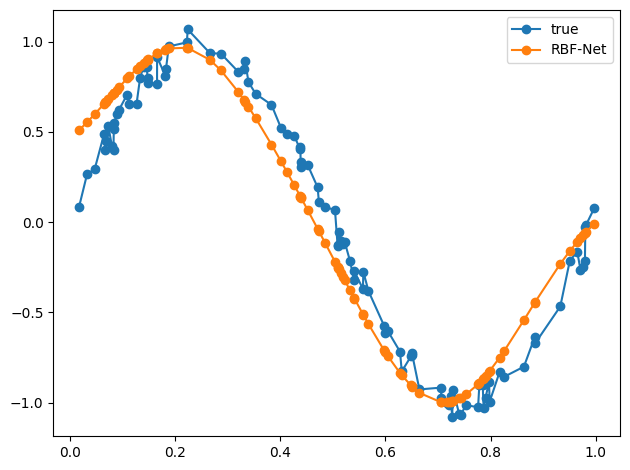

In [12]:
# CONFIGURACIÓN 1
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()

Vemos que se ajusta bastante bien.

# EJERCICIO
- Podemos  intentar  jugar  con  algunos  parámetros  clave,  como  el  número  de  bases.  ¿Qué  pasa  si 
aumentamos el número de bases a 4? ¿Es mejor el resultado? ¿Qué está ocurriendo? 
Otro  parámetro  que  podemos  cambiar  es  la  desviación  estándar.  ¿Qué  tal  si  usamos  una  única 
desviación estándar para todas nuestras bases en lugar de que cada una tenga su propia? 
Lanzad varias ejecuciones con diferentes parámetros buscando la mejor configuración para la Red 
Neuronal RBF. Recogedlos en una tabla y sacad conclusiones. 

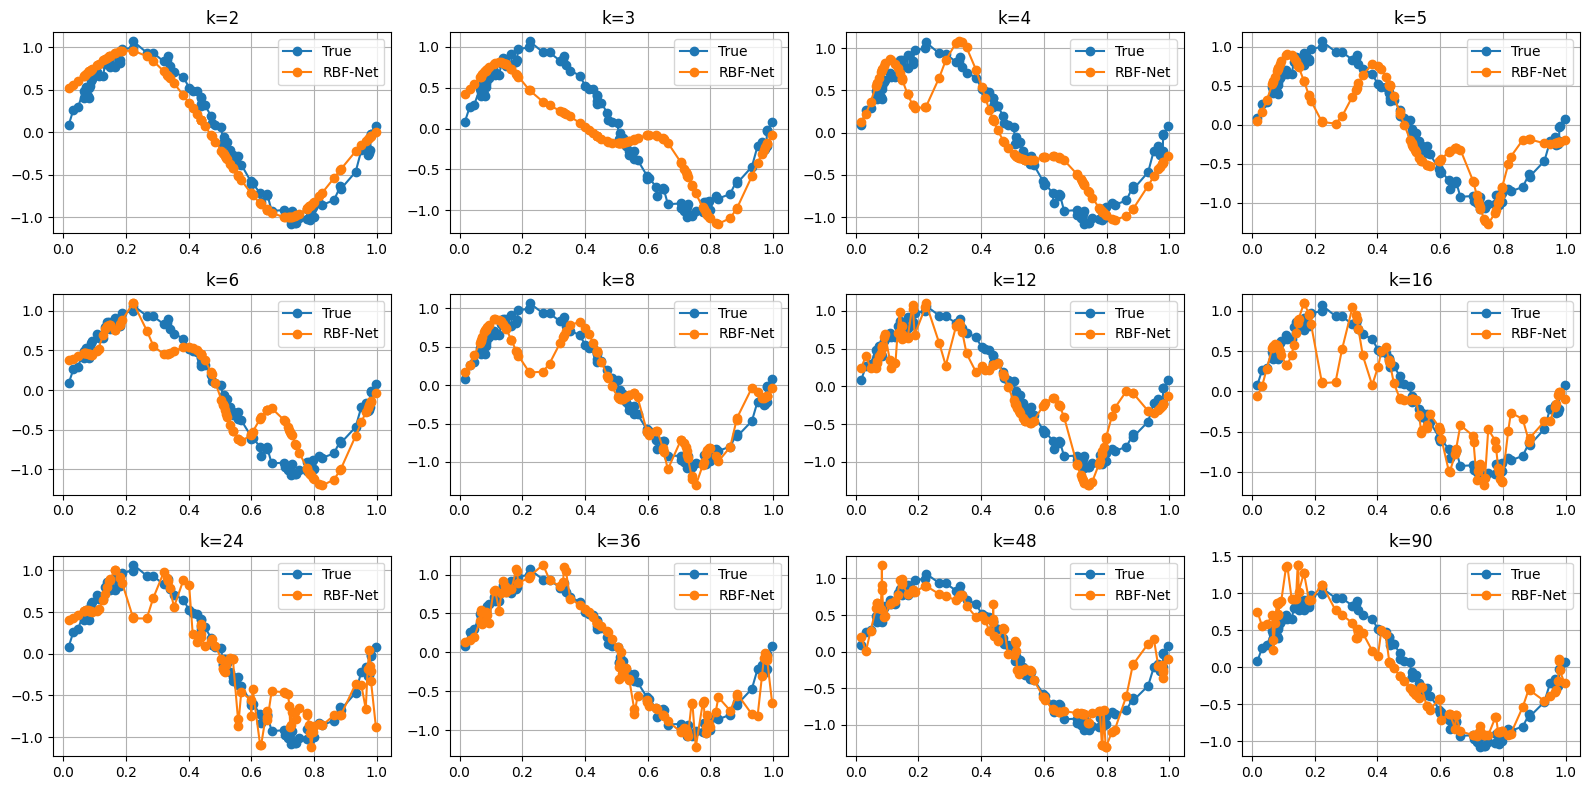

     k       MSE        R²
0    2  0.027587  0.939288
1    3  0.130503  0.712791
2    4  0.084115  0.814879
3    5  0.094543  0.791930
4    6  0.062346  0.862790
5    8  0.054342  0.880404
6   12  0.071412  0.842836
7   16  0.062972  0.861413
8   24  0.061047  0.865649
9   36  0.031184  0.931371
10  48  0.039767  0.912481
11  90  0.068868  0.848436


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

k_list = [2, 3, 4, 5, 6, 8, 12, 16, 24, 36, 48, 90]
metrics = [] 

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))

for i, k in enumerate(k_list):
    ax = axes[i // 4, i % 4]

    rbfnet = RBFNet(lr=1e-2, k=k, verbose=False)
    rbfnet.fit(X, y)
    y_pred = rbfnet.predict(X)

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    metrics.append({"k": k, "MSE": mse, "R²": r2})

    ax.plot(X, y, "-o", label="True")
    ax.plot(X, y_pred, "-o", label="RBF-Net")
    ax.set_title(f"k={k}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

- A mayor número de K la curva realizada por la red intenta crear mayor número de gaussianas, por lo que la curva termina ajustandose poco a la tendencia general y mucho al ruido de los datos, ya que a mayor K mayor número de tramos de la curva y menor número de puntos a tener en cuenta para cada gaussiana, por lo que se estarán teniendo en cuenta cada vez más ruido y menos datos reales. Además de que la gaussiana al intentar generar unos parámetros para cada tramo estará sobreajustando localmente.
- El mejor modelo dadas las métricas es el primero, que obtiene un r^2 muy alto y un error cuadrático medio bastante bajo. Ocurre lo anteriormente comentado, que mayor número de gaussianas no ajustan bien la curva.

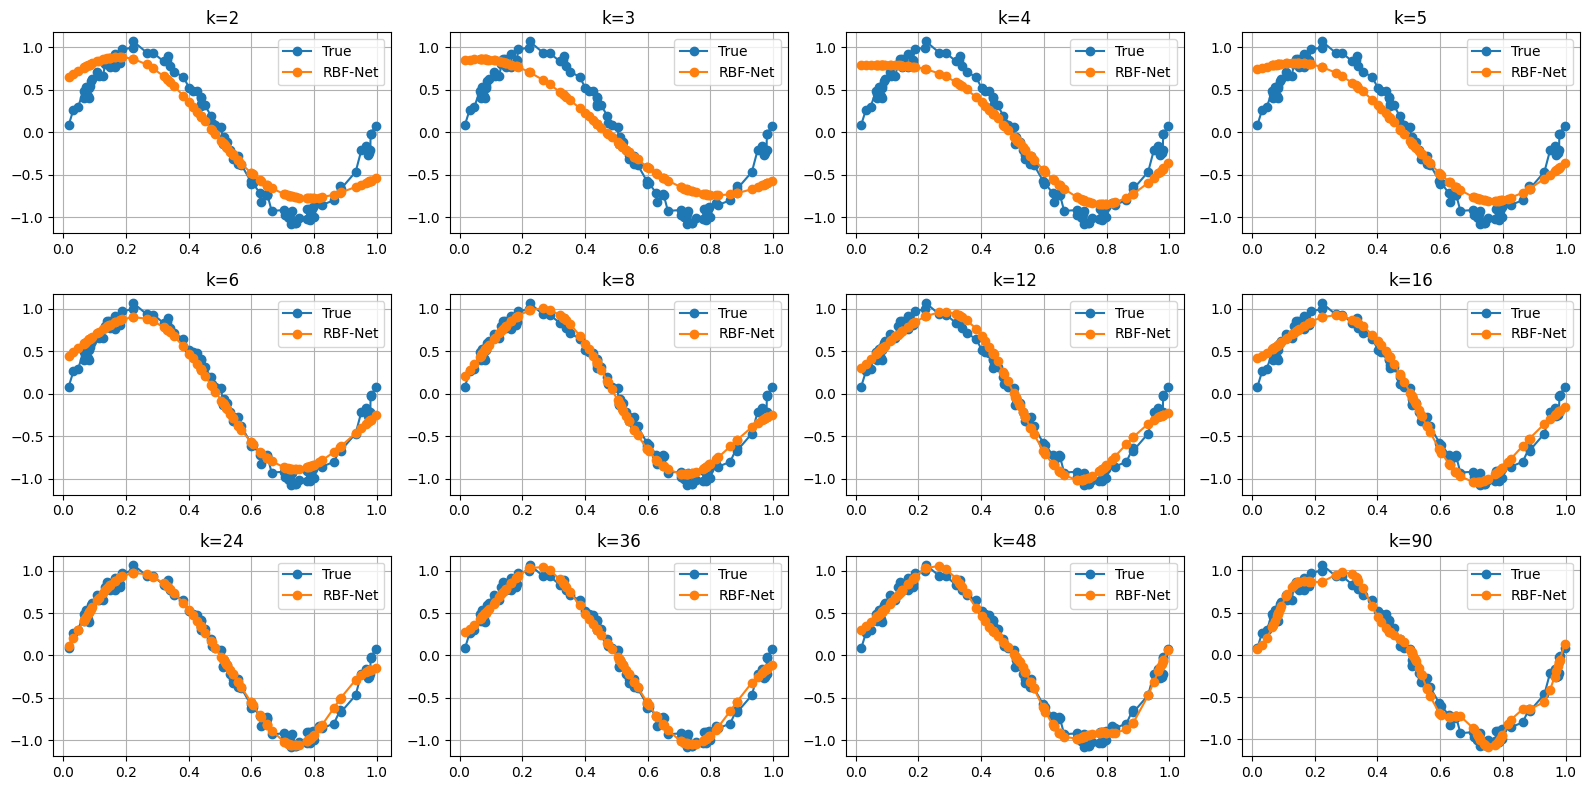

     k       MSE        R²
0    2  0.052921  0.883532
1    3  0.088330  0.805604
2    4  0.047318  0.895862
3    5  0.048084  0.894176
4    6  0.014198  0.968753
5    8  0.008284  0.981768
6   12  0.010683  0.976490
7   16  0.009477  0.979142
8   24  0.005075  0.988830
9   36  0.005216  0.988521
10  48  0.007069  0.984444
11  90  0.007890  0.982635


In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
metrics = [] 

for i, k in enumerate(k_list):
    ax = axes[i // 4, i % 4]

    rbfnet = RBFNet(lr=1e-2, k=k, inferStds=False, verbose=False)
    rbfnet.fit(X, y)
    y_pred = rbfnet.predict(X)

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    metrics.append({"k": k, "MSE": mse, "R²": r2})

    ax.plot(X, y, "-o", label="True")
    ax.plot(X, y_pred, "-o", label="RBF-Net")
    ax.set_title(f"k={k}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

- Al usar una única desviación estándar se está recortando la flexibilidad y complejidad del modelo.
- Cuando la desviación es fija, todas las funciones de base radial tienen la misma anchura y pueden generar una interpolación más suave.
- En este problema concreto es mejor opción debido a la naturaleza de este.